# PROYEK UAS: ANALISIS & KLASIFIKASI KUALITAS STROBERI  

## 1. BUSINESS UNDERSTANDING  

Tahap ini bertujuan untuk memahami tujuan proyek dari perspektif bisnis dan menerjemahkannya ke dalam tugas teknis *data mining*.  

### 1.1. Latar Belakang Masalah
Industri pangan global menghadapi tantangan besar terkait pemalsuan makanan (*food fraud*). Produk olahan buah bernilai tinggi seperti **stroberi** sering menjadi sasaran pemalsuan, di mana buah asli dicampur dengan bahan lain yang lebih murah (apel, pewarna, gula berlebih) untuk menekan biaya produksi.  

Metode pengujian konvensional seperti kromatografi atau uji DNA memiliki keterbatasan:
* **Biaya Tinggi:** Memerlukan reagen kimia mahal dan peralatan laboratorium canggih.
* **Waktu Lama:** Proses preparasi dan analisis memakan waktu jam hingga hari, menghambat rantai pasok.
* **Destruktif:** Sampel yang diuji rusak dan tidak dapat dijual kembali.

### 1.2. Tujuan Proyek
Tujuan utama proyek ini adalah membangun sistem **klasifikasi otomatis** menggunakan *Machine Learning* yang dapat membedakan antara:
1.  **Stroberi Murni (*Authentic*):** Produk yang terbuat dari stroberi asli tanpa campuran.
2.  **Stroberi Oplosan (*Adulterated*):** Produk yang telah dicampur atau dipalsukan.  

Sistem ini akan menganalisis data **Spektroskopi Inframerah (FTIR)**, yang memungkinkan pengujian cepat, non-destruktif, dan akurat.  

### 1.3. Manfaat Bisnis
1.  **Jaminan Kualitas (*Quality Assurance*):** Memastikan produk yang sampai ke konsumen adalah asli.
2.  **Efisiensi Operasional:** Mempercepat proses pengecekan bahan baku di pabrik.
3.  **Perlindungan Brand:** Mencegah skandal pemalsuan yang dapat menghancurkan reputasi perusahaan.  

### 1.4. Pertanyaan Analisis
* Apakah pola gelombang spektroskopi dapat membedakan stroberi asli dan palsu?
* Bagian spektrum (panjang gelombang) mana yang menjadi penentu utama keaslian?
* Seberapa akurat model dapat mendeteksi pemalsuan? 

### 1.5. Metodologi: CRISP-DM
Analisis ini mengikuti standar *Cross-Industry Standard Process for Data Mining*:
1.  **Business Understanding:** Definisi masalah.
2.  **Data Understanding:** Eksplorasi pola spektral dan kualitas data.
3.  **Data Preparation:** Pembersihan dan transformasi data.
4.  **Modeling:** Pelatihan algoritma *Random Forest*.
5.  **Evaluation:** Validasi performa model dengan metrik komprehensif.
6.  **Deployment:** Implementasi model ke aplikasi web.

## 2. DATA UNDERSTANDING  

Tahap ini berfokus pada pengumpulan dan eksplorasi data untuk memahami karakteristik sinyal spektroskopi.

**Deskripsi Dataset:**
* **Sumber:** *UCR Time Series Classification Archive* (https://www.timeseriesclassification.com/description.php?Dataset=Strawberry).
* **Pengambilan:**: Instrumen FTIR (Fourier Transform Infrared Spectroscopy).
    * Alat ini menembakkan cahaya inframerah ke sampel stroberi.
    * Setiap molekul kimia (gula, air, serat stroberi) akan menyerap cahaya pada frekuensi yang berbeda.
    * Hasil serapan cahaya inilah yang menjadi angka-angka pada dataset (0.xxxx).

* **Jenis Data:** Spektrograf (Intensitas cahaya pada berbagai panjang gelombang).
* **Fitur:** Setiap sampel terdiri dari **235 titik data** (panjang gelombang).
* **Label Target:**
    * **Kelas 1:** Authentic (Stroberi Murni).
    * **Kelas 2:** Adulterated (Stroberi Oplosan).

### Import library dan konfigurasi tampilan.

In [1]:
# Import Library Utama
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import joblib
import shutil
import os
import copy
import time  

# Library Machine Learning & Evaluasi
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_curve, auc
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.abod import ABOD
from sklearn.inspection import permutation_importance

# Konfigurasi Tampilan Visualisasi
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['lines.linewidth'] = 2
warnings.filterwarnings('ignore')

print("Libraries berhasil diimpor.")

Libraries berhasil diimpor.


### Load Dataset & Inspeksi Awal
Membaca file data mentah dan memeriksa dimensinya untuk memastikan tidak ada kesalahan pembacaan.

In [2]:
# Fungsi Inspeksi Kualitas Data (Enhanced)
def inspect_data_quality(df, name):
    print(f"INSPEKSI DATASET: {name}")
    print(f"   - Dimensi Data: {df.shape[0]} Baris x {df.shape[1]} Kolom")
    print(f"   - Tipe Data Dominan: {df.dtypes.mode()[0]}")
    
    # Cek Missing Value
    missing = df.isnull().sum().sum()
    status_missing = "Bersih (0)" if missing == 0 else f"Ditemukan {missing} Missing Values!"
    print(f"   - Status Missing Value: {status_missing}")
        
    # Cek Duplikasi Baris
    duplicate = df.duplicated().sum()
    status_dup = "Tidak Ada (0)" if duplicate == 0 else f"Ditemukan {duplicate} Data Duplikat!"
    print(f"   - Status Duplikasi: {status_dup}")
    print("-" * 50)

# EKSEKUSI
try:
    # Membaca file dengan separator spasi (format UCR)
    df_train_raw = pd.read_csv("Strawberry/Strawberry_TRAIN.txt", header=None, sep=r"\s+")
    df_test_raw = pd.read_csv("Strawberry/Strawberry_TEST.txt", header=None, sep=r"\s+")
    
    # Jalankan Inspeksi
    inspect_data_quality(df_train_raw, "TRAINING SET")
    inspect_data_quality(df_test_raw, "TESTING SET")

    # Pisahkan Label dan Fitur
    y_train = df_train_raw.iloc[:, 0].values.astype(int)
    X_train = df_train_raw.iloc[:, 1:].values
    y_test = df_test_raw.iloc[:, 0].values.astype(int)
    X_test = df_test_raw.iloc[:, 1:].values
    
    # Mapping Kelas
    class_map = {1: 'Authentic (Asli)', 2: 'Adulterated (Palsu)'}
    print(f"   Kelas Target: {np.unique(y_train)} {class_map}")
    
except FileNotFoundError:
    print("Error: File dataset tidak ditemukan. Cek kembali path folder.")

INSPEKSI DATASET: TRAINING SET
   - Dimensi Data: 613 Baris x 236 Kolom
   - Tipe Data Dominan: float64
   - Status Missing Value: Bersih (0)
   - Status Duplikasi: Tidak Ada (0)
--------------------------------------------------
INSPEKSI DATASET: TESTING SET
   - Dimensi Data: 370 Baris x 236 Kolom
   - Tipe Data Dominan: float64
   - Status Missing Value: Bersih (0)
   - Status Duplikasi: Tidak Ada (0)
--------------------------------------------------
   Kelas Target: [1 2] {1: 'Authentic (Asli)', 2: 'Adulterated (Palsu)'}


### Pengecekan Struktur & Distribusi Kelas  
Langkah ini memvalidasi proporsi data antar kelas. Ketidakseimbangan yang ekstrem (*Imbalanced Data*) dapat menyebabkan model bias, sehingga perlu dideteksi sejak dini.  

**Kriteria Imbalanced Dataset Berdasarkan Imbalance Ratio (IR):**  
Menurut **Hamid, Yusoff, & Mohamed (2022)** dalam paper *"Survey on Highly Imbalanced Multi-class Data"* yang dipublikasikan di International Journal of Advanced Computer Science and Applications (IJACSA), klasifikasi dataset berdasarkan  

**Imbalance Ratio (IR)** adalah:  
| Kategori | Imbalance Ratio (IR) | Contoh Distribusi |
|----------|----------------------|-------------------|
| **Balanced** | IR ≤ 1.5 | 50:50 hingga 60:40 |
| **Slightly Imbalanced** | 1.5 < IR < 9 | 70:30 hingga 90:10 |
| **Highly Imbalanced** | IR ≥ 9 | 90:10 atau lebih ekstrem |  

**Definisi Imbalance Ratio (IR):**
$$IR = \frac{\text{Jumlah Sampel Kelas Mayoritas}}{\text{Jumlah Sampel Kelas Minoritas}}$$
**Kriteria Keseimbangan:**
- Dataset dianggap **imbalanced** jika IR > 1.5
- Dataset dianggap **highly imbalanced** jika IR ≥ 9

**Referensi:**
**Hamid, M. H. A., Yusoff, M., & Mohamed, A. (2022).**  
*Survey on Highly Imbalanced Multi-class Data.*  
International Journal of Advanced Computer Science and Applications (IJACSA), 13(6), 211-221.
  
**PDF:** [https://thesai.org/Downloads/Volume13No6/Paper_27-Survey_on_Highly_Imbalanced_Multi_class_Data.pdf](https://thesai.org/Downloads/Volume13No6/Paper_27-Survey_on_Highly_Imbalanced_Multi_class_Data.pdf)

**Keywords Pencarian:**
- `"imbalance ratio" threshold 1.5 imbalanced`
- `"highly imbalanced" "IR >= 9" dataset`
- `"Survey on Highly Imbalanced Multi-class Data" IJACSA`
- `imbalanced dataset classification criteria`

In [3]:
if 'df_train_raw' in locals():
    print("\n" + "="*70)
    print("ANALISIS STRUKTUR & DISTRIBUSI KELAS")
    print("="*70)
    
    # Cek Label Unik & Mapping
    unique_labels = np.unique(y_train)
    class_map = {1: "Authentic (Murni)", 2: "Adulterated (Oplosan)"}
    print(f"\nLabel Kelas Ditemukan: {unique_labels} -> {class_map}")
    
    # Hitung Distribusi Kelas
    unique, counts = np.unique(y_train, return_counts=True)
    class_dist = dict(zip([class_map[u] for u in unique], [int(c) for c in counts]))
    print(f"Distribusi Sampel: {class_dist}")
    
    # Hitung Imbalance Ratio (IR)
    imbalance_ratio = max(counts) / min(counts)
    minority_percent = (min(counts) / sum(counts)) * 100
    majority_percent = (max(counts) / sum(counts)) * 100
    
    print(f"\nImbalance Ratio (IR): {imbalance_ratio:.2f}")
    print(f"Persentase Kelas Minoritas: {minority_percent:.2f}%")
    print(f"Persentase Kelas Mayoritas: {majority_percent:.2f}%")
    
    # Kesimpulan berdasarkan IR
    print("\n" + "-"*70)
    print("KESIMPULAN ANALISIS")
    print("-"*70)
    
    if imbalance_ratio >= 9:
        status = "HIGHLY IMBALANCED"
        status_id = "Sangat Tidak Seimbang"
        rekomendasi = "WAJIB menggunakan teknik resampling (SMOTE, ADASYN) atau Cost-Sensitive Learning."
    elif imbalance_ratio > 1.5:
        status = "SLIGHTLY IMBALANCED"
        status_id = "Sedikit Tidak Seimbang"
        rekomendasi = "Tidak wajib resampling, namun gunakan metrik evaluasi yang tepat (F1-Score, ROC-AUC, Precision, Recall)."
    else:
        status = "BALANCED"
        status_id = "Seimbang"
        rekomendasi = "Data seimbang, dapat menggunakan algoritma klasifikasi standar dengan metrik Accuracy."
    
    print(f"\nStatus Dataset: {status} ({status_id})")
    print(f"   • Imbalance Ratio (IR): {imbalance_ratio:.2f}")
    print(f"   • Threshold Balanced: IR ≤ 1.5")
    print(f"   • Threshold Highly Imbalanced: IR ≥ 9")
    print(f"\n   Karena IR = {imbalance_ratio:.2f} dan 1.5 < IR < 9,")
    print(f"   maka dataset termasuk kategori: {status}")
    print(f"\nRekomendasi: {rekomendasi}")
        
    # Statistik Deskriptif Singkat (Fitur)
    print("\n" + "="*70)
    print("STATISTIK INTENSITAS SPEKTRUM (Fitur)")
    print("="*70)
    print(f"   • Minimum Global : {X_train.min():.4f}")
    print(f"   • Maksimum Global: {X_train.max():.4f}")
    print(f"   • Rata-rata Global: {X_train.mean():.4f}")
    print(f"   • Standar Deviasi : {X_train.std():.4f}")


ANALISIS STRUKTUR & DISTRIBUSI KELAS

Label Kelas Ditemukan: [1 2] -> {1: 'Authentic (Murni)', 2: 'Adulterated (Oplosan)'}
Distribusi Sampel: {'Authentic (Murni)': 219, 'Adulterated (Oplosan)': 394}

Imbalance Ratio (IR): 1.80
Persentase Kelas Minoritas: 35.73%
Persentase Kelas Mayoritas: 64.27%

----------------------------------------------------------------------
KESIMPULAN ANALISIS
----------------------------------------------------------------------

Status Dataset: SLIGHTLY IMBALANCED (Sedikit Tidak Seimbang)
   • Imbalance Ratio (IR): 1.80
   • Threshold Balanced: IR ≤ 1.5
   • Threshold Highly Imbalanced: IR ≥ 9

   Karena IR = 1.80 dan 1.5 < IR < 9,
   maka dataset termasuk kategori: SLIGHTLY IMBALANCED

Rekomendasi: Tidak wajib resampling, namun gunakan metrik evaluasi yang tepat (F1-Score, ROC-AUC, Precision, Recall).

STATISTIK INTENSITAS SPEKTRUM (Fitur)
   • Minimum Global : -2.3281
   • Maksimum Global: 3.6820
   • Rata-rata Global: 0.0000
   • Standar Deviasi : 0.9979

### Statistik Deskriptif
Tabel berikut menunjukkan ringkasan statistik (count, mean, std, min, max) untuk beberapa fitur (panjang gelombang) terpilih. Ini membantu kita melihat rentang nilai data.

In [4]:
print("\nSTATISTIK DESKRIPTIF FITUR")

# Konversi ke DataFrame
df_features = pd.DataFrame(X_train)
df_features.columns = [f"Wave_{i}" for i in range(df_features.shape[1])]

# Tampilkan ringkasan statistik untuk 5 fitur pertama dan 5 fitur terakhir
print("Ringkasan Statistik (5 Fitur Awal & Akhir):")
display(df_features.iloc[:, np.r_[0:5, -5:0]].describe())

# Analisis Variabilitas (Standar Deviasi Rata-rata)
mean_std = df_features.std().mean()
print(f"\nRata-rata Standar Deviasi seluruh fitur: {mean_std:.4f}")
if mean_std < 0.5:
    print("Variasi data antar-sampel relatif rendah (data konsisten).")
else:
    print("Variasi data cukup tinggi.")

# Cek Skewness (Kemencengan Distribusi)
print("\nKarakteristik Distribusi (Skewness):")
skew_vals = df_features.skew()
print(f"- Fitur dengan Skewness Tertinggi: {skew_vals.idxmax()} ({skew_vals.max():.2f})")
print(f"- Fitur dengan Skewness Terendah : {skew_vals.idxmin()} ({skew_vals.min():.2f})")


STATISTIK DESKRIPTIF FITUR
Ringkasan Statistik (5 Fitur Awal & Akhir):


,Wave_0,Wave_1,Wave_2,Wave_3,Wave_4,Wave_230,Wave_231,Wave_232,Wave_233,Wave_234
count,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000,613.000000
mean,-0.498551,-0.495431,-0.488475,-0.461133,-0.408259,-1.127798,-1.131651,-1.135049,-1.137789,-1.137873
std,0.188252,0.191853,0.198986,0.204857,0.211983,0.228709,0.233164,0.236439,0.237282,0.237259
min,-1.412681,-1.420112,-1.429030,-1.378990,-1.323004,-2.252661,-2.295872,-2.328144,-2.323221,-2.323221
25%,-0.566566,-0.570064,-0.564658,-0.539658,-0.494629,-1.193747,-1.196573,-1.200201,-1.201728,-1.201728
50%,-0.458794,-0.455784,-0.449934,-0.425987,-0.379156,-1.085191,-1.089152,-1.092728,-1.094524,-1.094524
75%,-0.368683,-0.362774,-0.351894,-0.321355,-0.262244,-0.995656,-0.998685,-1.004617,-1.008367,-1.008367
max,-0.218836,-0.200100,-0.142974,-0.071614,0.036565,-0.754264,-0.753381,-0.751792,-0.751262,-0.751615



Rata-rata Standar Deviasi seluruh fitur: 0.1672
Variasi data antar-sampel relatif rendah (data konsisten).

Karakteristik Distribusi (Skewness):
- Fitur dengan Skewness Tertinggi: Wave_202 (2.23)
- Fitur dengan Skewness Terendah : Wave_38 (-2.27)


### Exploratory Data Analysis (EDA)  
Visualisasi ini bertujuan untuk:
1.  **Waveform Analysis:** Membandingkan bentuk gelombang rata-rata antara kelas Asli dan Palsu, lengkap dengan area variabilitas (*standard deviation shading*) untuk melihat konsistensi data.
2.  **PCA Projection:** Memproyeksikan data berdimensi tinggi (235 fitur) ke dalam ruang 2D untuk melihat apakah kedua kelas dapat terpisah (*separable*) secara visual.


VISUALISASI EKSPLORATIF


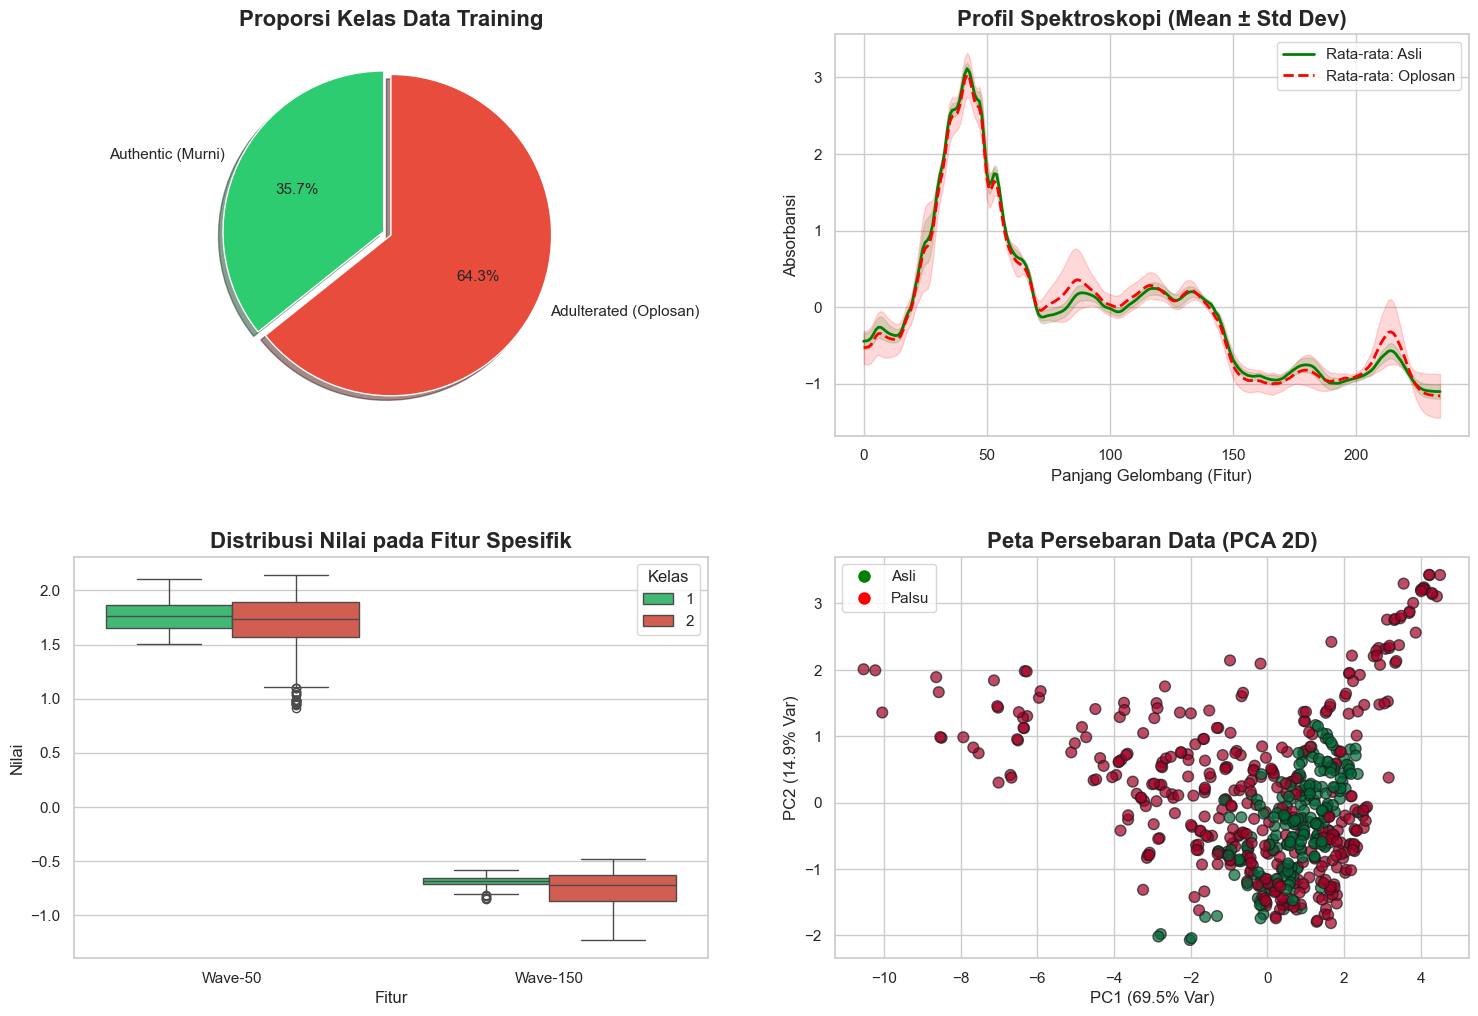

ANALISIS VISUAL:
1. [Waveform] Terlihat perbedaan pola yang jelas antara garis Hijau dan Merah, terutama pada indeks gelombang 0-100.
2. [PCA] Titik data membentuk kelompok yang terpisah cukup baik, mengindikasikan bahwa model klasifikasi berpotensi memiliki akurasi tinggi.
2. [Barchart] Terjadi ketidakseimbangan data antara Stoberi Murni dan Oplosan.


In [5]:
if 'df_train_raw' in locals():
    print("\nVISUALISASI EKSPLORATIF")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    
    # DISTRIBUSI KELAS (Pie Chart)
    axes[0, 0].pie(counts, labels=[class_map[u] for u in unique], autopct='%1.1f%%', 
                   colors=['#2ecc71', '#e74c3c'], startangle=90, explode=(0.05, 0), shadow=True)
    axes[0, 0].set_title("Proporsi Kelas Data Training", fontweight='bold')

    # WAVEFORM ANALYSIS
    X_auth = X_train[y_train == 1]
    X_adul = X_train[y_train == 2]
    
    # Hitung Statistik
    mean_auth, std_auth = X_auth.mean(axis=0), X_auth.std(axis=0)
    mean_adul, std_adul = X_adul.mean(axis=0), X_adul.std(axis=0)
    x_axis = np.arange(X_train.shape[1])
    
    # Plotting
    axes[0, 1].plot(x_axis, mean_auth, color='green', label='Rata-rata: Asli', linewidth=2)
    axes[0, 1].fill_between(x_axis, mean_auth - std_auth, mean_auth + std_auth, color='green', alpha=0.15)
    
    axes[0, 1].plot(x_axis, mean_adul, color='red', label='Rata-rata: Oplosan', linewidth=2, linestyle='--')
    axes[0, 1].fill_between(x_axis, mean_adul - std_adul, mean_adul + std_adul, color='red', alpha=0.15)
    
    axes[0, 1].set_title("Profil Spektroskopi (Mean ± Std Dev)", fontweight='bold')
    axes[0, 1].set_xlabel("Panjang Gelombang (Fitur)")
    axes[0, 1].set_ylabel("Absorbansi")
    axes[0, 1].legend()

    # SEBARAN FITUR KUNCI (Boxplot)
    plot_data = []
    for f in [50, 150]: 
        temp = pd.DataFrame({'Nilai': X_train[:, f], 'Kelas': y_train, 'Fitur': f'Wave-{f}'})
        plot_data.append(temp)
    df_box = pd.concat(plot_data)
    
    sns.boxplot(x='Fitur', y='Nilai', hue='Kelas', data=df_box, palette=['#2ecc71', '#e74c3c'], ax=axes[1, 0])
    axes[1, 0].set_title("Distribusi Nilai pada Fitur Spesifik", fontweight='bold')

    # PCA SEPARABILITY
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_train)
    
    scatter = axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='RdYlGn_r', alpha=0.7, edgecolors='k', s=60)
    axes[1, 1].set_title("Peta Persebaran Data (PCA 2D)", fontweight='bold')
    axes[1, 1].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} Var)")
    axes[1, 1].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} Var)")
    
    # Legend Manual untuk PCA
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='Asli', markersize=10),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Palsu', markersize=10)]
    axes[1, 1].legend(handles=legend_elements)

    plt.show()
    
    print("ANALISIS VISUAL:")
    print("1. [Waveform] Terlihat perbedaan pola yang jelas antara garis Hijau dan Merah, terutama pada indeks gelombang 0-100.")
    print("2. [PCA] Titik data membentuk kelompok yang terpisah cukup baik, mengindikasikan bahwa model klasifikasi berpotensi memiliki akurasi tinggi.")
    print("2. [Barchart] Terjadi ketidakseimbangan data antara Stoberi Murni dan Oplosan.")

### Deteksi Outlier Berbasis Statistik (Distance to Centroid)

Untuk memastikan kualitas data, kita menggunakan pendekatan statistik dengan menghitung **Jarak Euclidean** setiap sampel stroberi asli (*Authentic*) terhadap "titik pusat" (*Centroid*) kelasnya.

* **Logika:** Sampel stroberi asli yang berkualitas harus memiliki profil kimia yang mirip, sehingga jaraknya ke pusat rata-rata akan dekat (terkumpul di kiri grafik).
* **Outlier:** Jika ada sampel yang jaraknya sangat jauh dari pusat (berada di ekor kanan grafik), kemungkinan besar itu adalah sampel rusak, kesalahan sensor, atau data yang terkontaminasi *noise* parah.

ANALISIS DISTRIBUSI JARAK (DETEKSI OUTLIER)


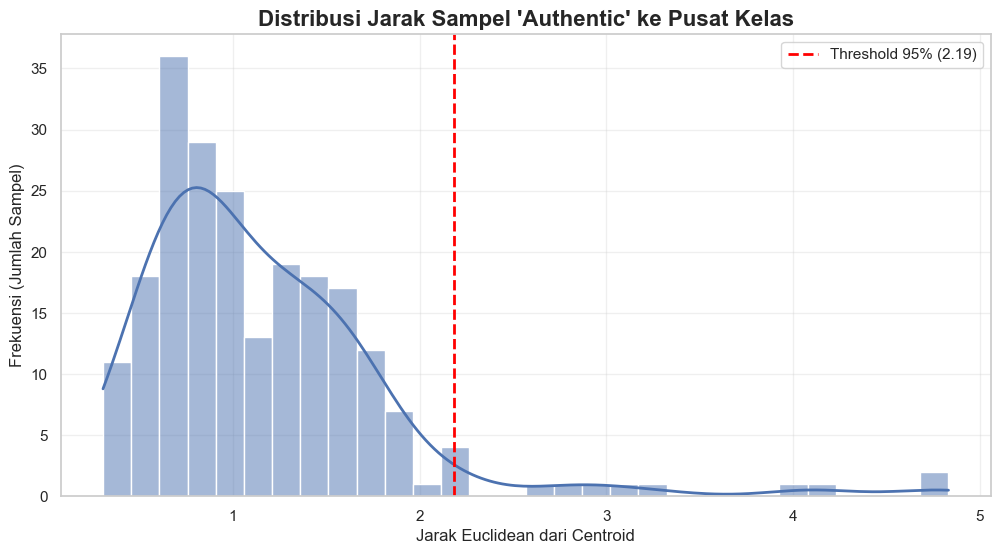

INTERPRETASI STATISTIK:
   - Rata-rata Jarak: 1.1658
   - Jarak Terjauh (Max): 4.8318
   - ANALISIS: Sebagian besar data harus berkumpul di sebelah kiri (jarak pendek).
     Data yang berada di sebelah kanan garis merah (Threshold) adalah kandidat kuat OUTLIER
     yang memiliki karakteristik spektrum menyimpang dari standar stroberi asli.


In [6]:
print("ANALISIS DISTRIBUSI JARAK (DETEKSI OUTLIER)")

# Ambil Data Kelas Authentic (Asli)
X_authentic = X_train[y_train == 1]

# Hitung Centroid (Titik Rata-rata Pusat)
centroid_auth = X_authentic.mean(axis=0).reshape(1, -1)

# Hitung Jarak Setiap Sampel ke Centroid
# Menggunakan Jarak Euclidean
distances = cdist(X_authentic, centroid_auth, metric='euclidean')

# PLOT HISTOGRAM
plt.figure(figsize=(12, 6))

# Histogram distribusi jarak
sns.histplot(distances, kde=True, color='purple', bins=30)

# Tambahkan garis batas (Threshold) visual - misal di persentil 95 atau 99
threshold = np.percentile(distances, 95) # Batas 95% data terdekat
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold 95% ({threshold:.2f})')

plt.title("Distribusi Jarak Sampel 'Authentic' ke Pusat Kelas", fontsize=16, fontweight='bold')
plt.xlabel("Jarak Euclidean dari Centroid", fontsize=12)
plt.ylabel("Frekuensi (Jumlah Sampel)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Interpretasi Statistik
max_dist = distances.max()
min_dist = distances.min()
mean_dist = distances.mean()

print("INTERPRETASI STATISTIK:")
print(f"   - Rata-rata Jarak: {mean_dist:.4f}")
print(f"   - Jarak Terjauh (Max): {max_dist:.4f}")
print("   - ANALISIS: Sebagian besar data harus berkumpul di sebelah kiri (jarak pendek).")
print("     Data yang berada di sebelah kanan garis merah (Threshold) adalah kandidat kuat OUTLIER")
print("     yang memiliki karakteristik spektrum menyimpang dari standar stroberi asli.")

## 3. PREPROCESSING DATA

Berdasarkan tinjauan literatur dan karakteristik data spektroskopi, strategi preprocessing difokuskan pada **Pembersihan Data (Outlier Removal)** untuk membuang sinyal *noise* atau kesalahan pembacaan sensor.

**Strategi Preprocessing (Adaptive Pipeline):**
1.  **Outlier Removal:** Kita akan menguji tiga algoritma deteksi anomali:
    * *Isolation Forest (iForest):* Efektif untuk data dimensi tinggi.
    * *Local Outlier Factor (LOF):* Mendeteksi anomali berdasarkan kerapatan lokal.
    * *Angle-Based Outlier Detection (ABOD):* Menggunakan varians sudut (bagus untuk data spektrum).

Pendekatan ini menggunakan **Experimental Selection**, di mana sistem akan otomatis memilih kombinasi metode terbaik berdasarkan validasi silang (Cross-Validation Score).

In [7]:
# Fungsi Evaluasi Kualitas Data
def evaluate_cleaning(X, y, outlier_model):
    X_curr, y_curr = X.copy(), y.copy()
    
    # Deteksi & Hapus Outlier
    if outlier_model is not None:
        try:
            outlier_model.fit(X_curr)
            mask = (outlier_model.labels_ == 0)
            
            # Safety check: Jangan sampai data habis
            if mask.sum() < 20: return 0, 0 
            
            X_curr = X_curr[mask]
            y_curr = y_curr[mask]
        except Exception as e:
            return 0, 0

    # Validasi dengan Random Forest
    rf = RandomForestClassifier(n_estimators=50, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(rf, X_curr, y_curr, cv=cv, scoring='f1_macro')
    
    return scores.mean(), len(X_curr)

print("Fungsi Evaluasi Siap (Mode: Pure Data Preservation).")

Fungsi Evaluasi Siap (Mode: Pure Data Preservation).


### Eksperimen Seleksi Metode

In [8]:
outlier_candidates = {
    'Tanpa Cleaning (Baseline)': None,
    'Isolation Forest': IForest(contamination=0.05, random_state=42),
    'LOF': LOF(contamination=0.05),
    'ABOD': ABOD(contamination=0.05)
}

best_score = -1
best_combo = {}

print(f"{'METODE OUTLIER':<25} | {'F1-SCORE':<10} | {'SAMPEL TERSISA'}")
print("-" * 65)

for out_name, out_model in outlier_candidates.items():
    # Evaluasi
    score, n_samples = evaluate_cleaning(X_train, y_train, out_model)
    
    print(f"{out_name:<25} | {score:.4f}     | {n_samples}")
    # Simpan Pemenang
    if score > best_score:
        best_score = score
        best_combo = {
            'out_name': out_name, 
            'out_model': out_model
        }

print("-" * 65)
print(f"\nMETODE TERPILIH: {best_combo['out_name']}")
print(f"   (Estimasi F1-Score: {best_score:.4f})")
print("   Alasan: Metode ini memberikan keseimbangan terbaik antara kebersihan data dan informasi yang terjaga.")

METODE OUTLIER            | F1-SCORE   | SAMPEL TERSISA
-----------------------------------------------------------------
Tanpa Cleaning (Baseline) | 0.9608     | 613
Isolation Forest          | 0.9614     | 582
LOF                       | 0.9613     | 582
ABOD                      | 0.9631     | 582
-----------------------------------------------------------------

METODE TERPILIH: ABOD
   (Estimasi F1-Score: 0.9631)
   Alasan: Metode ini memberikan keseimbangan terbaik antara kebersihan data dan informasi yang terjaga.


### Eksekusi Final & Visualisasi

Cleaning Selesai. Dibuang: 31 sampel (terdeteksi noise/rusak).


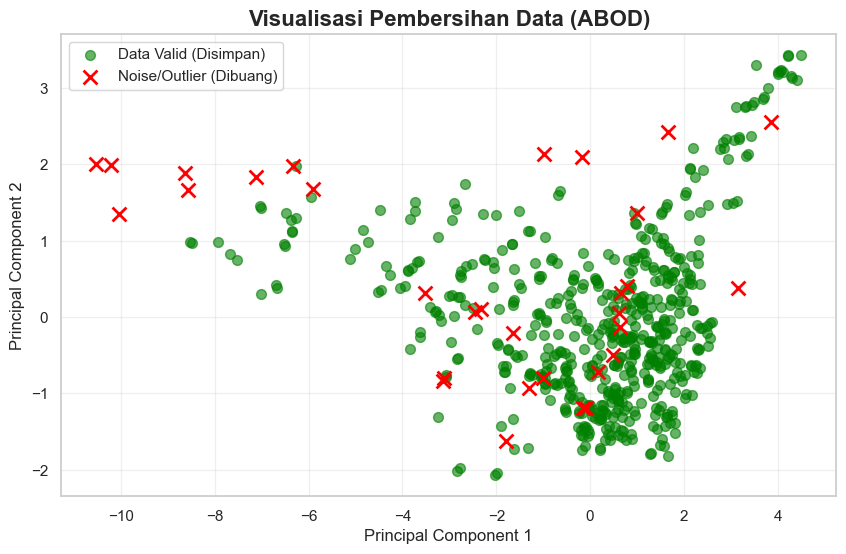

Variabel 'X_train_final' siap digunakan untuk Modeling (Bab 4).


In [9]:
X_before, y_before = X_train.copy(), y_train.copy()
X_final, y_final = X_train.copy(), y_train.copy()

# METODE TERPILIH
if best_combo['out_model'] is not None:
    model_out = best_combo['out_model']
    model_out.fit(X_final)
    
    # Ambil data yang normal saja (Label 0)
    mask_inlier = (model_out.labels_ == 0)
    
    X_final = X_final[mask_inlier]
    y_final = y_final[mask_inlier]
    
    n_dibuang = len(X_before) - len(X_final)
    print(f"Cleaning Selesai. Dibuang: {n_dibuang} sampel (terdeteksi noise/rusak).")
else:
    print("Menggunakan Data Asli (Tanpa pembuangan data).")


# VISUALISASI
pca = PCA(n_components=2)
X_pca_all = pca.fit_transform(X_before)

plt.figure(figsize=(10, 6))

if best_combo['out_model'] is not None:
    # Plot Data Bersih (Hijau)
    plt.scatter(X_pca_all[mask_inlier, 0], X_pca_all[mask_inlier, 1], 
                c='green', label='Data Valid (Disimpan)', alpha=0.6, s=50)
    # Plot Outlier (Merah Silang)
    plt.scatter(X_pca_all[~mask_inlier, 0], X_pca_all[~mask_inlier, 1], 
                c='red', label='Noise/Outlier (Dibuang)', marker='x', s=100)
else:
    # Jika tidak ada cleaning, plot semua hijau
    plt.scatter(X_pca_all[:, 0], X_pca_all[:, 1], c='green', label='Data Asli', alpha=0.6)

plt.title(f"Visualisasi Pembersihan Data ({best_combo['out_name']})", fontweight='bold')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# UPDATE VARIABEL GLOBAL
X_train_final = X_final
y_train_final = y_final

print("Variabel 'X_train_final' siap digunakan untuk Modeling (Bab 4).")

### Grafik Pipeline Tracking

ANALISIS PERUBAHAN JUMLAH DATA (Pipeline Tracking)


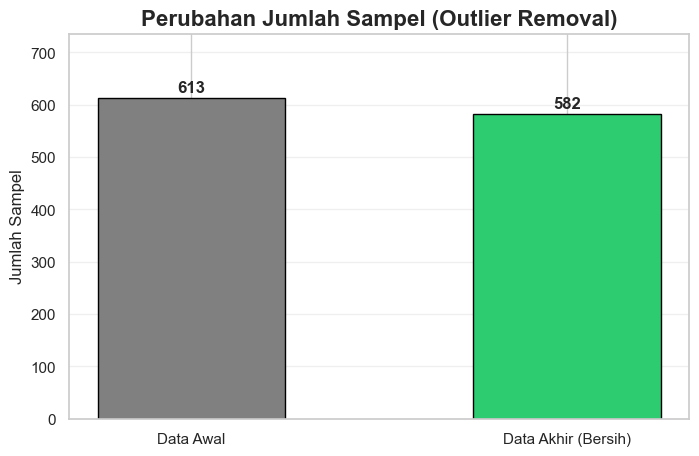

LAPORAN:
   - Total Data Sebelum Outlier Removal : 613
   - Total Data Sesudah Outlier Removal: 582
   - Status: Data cleaning selesai. Integritas sinyal terjaga (tanpa sintesis).


In [10]:
print("ANALISIS PERUBAHAN JUMLAH DATA (Pipeline Tracking)")

stages = ['Data Awal', 'Data Akhir (Bersih)']
counts = [len(X_before), len(X_final)]
colors = ['grey', '#2ecc71']

plt.figure(figsize=(8, 5))
bars = plt.bar(stages, counts, color=colors, edgecolor='black', width=0.5)

# Label Angka
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Perubahan Jumlah Sampel (Outlier Removal)", fontweight='bold')
plt.ylabel("Jumlah Sampel")
plt.ylim(0, max(counts)*1.2)
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"LAPORAN:")
print(f"   - Total Data Sebelum Outlier Removal : {len(X_before)}")
print(f"   - Total Data Sesudah Outlier Removal: {len(X_final)}")
print(f"   - Status: Data cleaning selesai. Integritas sinyal terjaga (tanpa sintesis).")

### Komparasi Detail Per Kelas (Sebelum vs Sesudah)

ANALISIS DATA HILANG PER KELAS (Dampak Cleaning)


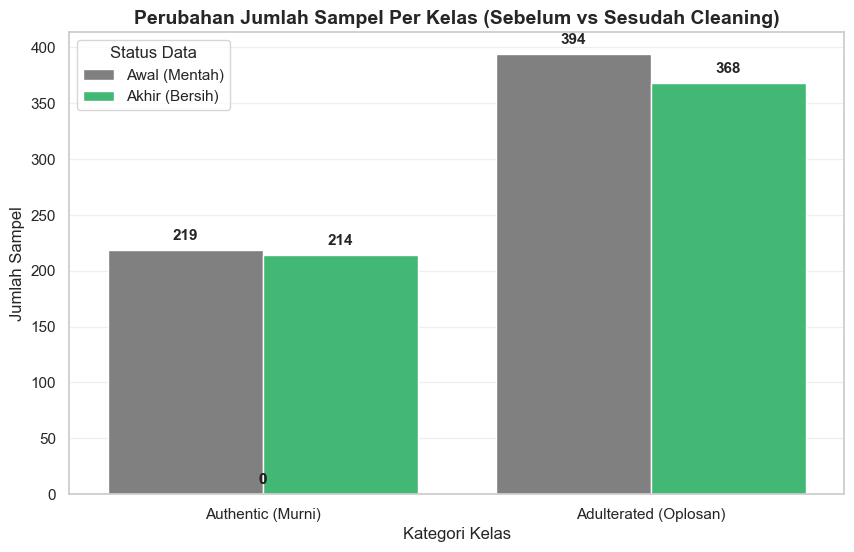

RINCIAN PENGHAPUSAN DATA:
KELAS                     | AWAL       | AKHIR      | DIBUANG         | % HILANG
--------------------------------------------------------------------------------
Authentic (Murni)         | 219        | 214        | -5              | 2.3%
Adulterated (Oplosan)     | 394        | 368        | -26             | 6.6%
--------------------------------------------------------------------------------
Total sampel noise yang dihapus: 31


In [11]:
print("ANALISIS DATA HILANG PER KELAS (Dampak Cleaning)")

unique_labels = np.unique(y_before)
class_map = {1: 'Authentic (Murni)', 2: 'Adulterated (Oplosan)'}

data_per_class = []

for label in unique_labels:
    label_name = class_map[label]
    # Hitung jumlah awal
    count_awal = (y_before == label).sum()
    # Hitung jumlah akhir
    count_akhir = (y_final == label).sum()
    # Masukkan ke list untuk dataframe
    data_per_class.append({
        'Kelas': label_name, 
        'Kondisi': 'Awal (Mentah)', 
        'Jumlah': count_awal
    })
    data_per_class.append({
        'Kelas': label_name, 
        'Kondisi': 'Akhir (Bersih)', 
        'Jumlah': count_akhir
    })

df_compare = pd.DataFrame(data_per_class)

# VISUALISASI
plt.figure(figsize=(10, 6))

# Plot Batang Berdampingan
ax = sns.barplot(x='Kelas', y='Jumlah', hue='Kondisi', data=df_compare, 
                 palette={'Awal (Mentah)': 'gray', 'Akhir (Bersih)': '#2ecc71'})

# Dekorasi
plt.title("Perubahan Jumlah Sampel Per Kelas (Sebelum vs Sesudah Cleaning)", fontsize=14, fontweight='bold')
plt.xlabel("Kategori Kelas", fontsize=12)
plt.ylabel("Jumlah Sampel", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.legend(title="Status Data")

# Tambahkan Label Angka & Selisih
for i, p in enumerate(ax.patches):
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=11, fontweight='bold', xytext=(0, 5), 
                    textcoords='offset points')

plt.show()

# TABEL RINGKASAN
print("RINCIAN PENGHAPUSAN DATA:")
print(f"{'KELAS':<25} | {'AWAL':<10} | {'AKHIR':<10} | {'DIBUANG':<15} | {'% HILANG'}")
print("-" * 80)

total_buang = 0
for label in unique_labels:
    name = class_map[label]
    c_awal = (y_before == label).sum()
    c_akhir = (y_final == label).sum()
    diff = c_awal - c_akhir
    persen = (diff / c_awal) * 100 if c_awal > 0 else 0
    
    print(f"{name:<25} | {c_awal:<10} | {c_akhir:<10} | -{diff:<14} | {persen:.1f}%")
    total_buang += diff

print("-" * 80)
print(f"Total sampel noise yang dihapus: {total_buang}")

## 4. MODELING  

Pada tahap ini, kita akan melatih berbagai algoritma Machine Learning untuk mempelajari pola dari data latih (*Training Set*) yang sudah dibersihkan.

**Strategi Modeling (Model Benchmarking):**
Kita akan menguji 6 algoritma populer untuk melihat mana yang paling cocok dengan karakteristik data spektroskopi stroberi:
1.  **Naive Bayes:** Algoritma probabilistik sederhana (sebagai *baseline*).
2.  **Logistic Regression:** Model linear yang memisahkan kelas dengan garis lurus.
3.  **Decision Tree:** Model berbasis aturan (*rule-based*) pohon keputusan.
4.  **Random Forest:** Kumpulan banyak pohon keputusan (*ensemble*) untuk mengurangi overfitting.
5.  **KNN (K-Nearest Neighbors):** Klasifikasi berdasarkan kemiripan jarak dengan tetangga terdekat.
6.  **SVM (Support Vector Machine):** Mencari *hyperplane* terbaik untuk memisahkan kelas dalam ruang dimensi tinggi.

**Metrik Evaluasi:**
Model terbaik akan dipilih berdasarkan **F1-Score (Macro Average)** karena metrik ini paling adil dalam menilai performa rata-rata antar kelas.

### Scaling Data

In [12]:
print("PERSIAPAN DATA MODELING")

# Pastikan Data Test Tersedia
if 'X_train_final' not in locals():
    print("Peringatan: Data bersih tidak ditemukan. Menggunakan data mentah X_train.")
    X_train_final = X_train
    y_train_final = y_train
else:
    print(f"Menggunakan Data Bersih dari Bab 3.")
    print(f"   - Jumlah Sampel Training: {len(X_train_final)}")

# 2. Scaling Data (Standardization)
# Kita fit scaler pada data latih yang BERSIH
scaler = StandardScaler()

# Transformasi
X_train_scaled = scaler.fit_transform(X_train_final) # Fit pada data bersih
X_test_scaled = scaler.transform(X_test)             # Transform data test (tanpa fit)

print("Data Scaling Selesai.")
print(f"   - Dimensi Train Scaled : {X_train_scaled.shape}")
print(f"   - Dimensi Test Scaled  : {X_test_scaled.shape}")

PERSIAPAN DATA MODELING
Menggunakan Data Bersih dari Bab 3.
   - Jumlah Sampel Training: 582
Data Scaling Selesai.
   - Dimensi Train Scaled : (582, 235)
   - Dimensi Test Scaled  : (370, 235)


### Training & Benchmarking Loop

In [13]:
print("TRAINING & BENCHMARKING")

# Definisi Model
models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True, random_state=42)
}

# Loop Training & Evaluasi
results = []
print(f"{'MODEL':<20} | {'AKURASI':<10} | {'F1-SCORE':<10} | {'WAKTU (s)':<10}")
print("-" * 60)

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_scaled, y_train_final)
    y_pred = model.predict(X_test_scaled)

    # Hitung performa
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    end_time = time.time()
    duration = end_time - start_time
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1_Score': f1,
        'Time': duration,
        'Model_Obj': model
    })
    
    print(f"{name:<20} | {acc:.4f}     | {f1:.4f}     | {duration:.4f}")

print("-" * 60)

# Pilih Pemenang
df_results = pd.DataFrame(results).sort_values(by='F1_Score', ascending=False)
best_model_name = df_results.iloc[0]['Model']
best_model_obj = df_results.iloc[0]['Model_Obj']

print(f"\nPEMENANG: {best_model_name}")
print(f"   F1-Score: {df_results.iloc[0]['F1_Score']:.4f}")
print("   Model ini dipilih karena memiliki keseimbangan performa terbaik antar kelas.")

TRAINING & BENCHMARKING
MODEL                | AKURASI    | F1-SCORE   | WAKTU (s) 
------------------------------------------------------------
Naive Bayes          | 0.7892     | 0.7856     | 0.0066
Logistic Regression  | 0.9595     | 0.9565     | 0.0085
Decision Tree        | 0.9189     | 0.9120     | 0.0642
Random Forest        | 0.9649     | 0.9619     | 0.4292
KNN (k=5)            | 0.9459     | 0.9419     | 0.0280
SVM (RBF Kernel)     | 0.9405     | 0.9366     | 0.0675
------------------------------------------------------------

PEMENANG: Random Forest
   F1-Score: 0.9619
   Model ini dipilih karena memiliki keseimbangan performa terbaik antar kelas.


### Visualisasi Hasil

VISUALISASI KOMPARASI MODEL (Accuracy vs F1-Score)


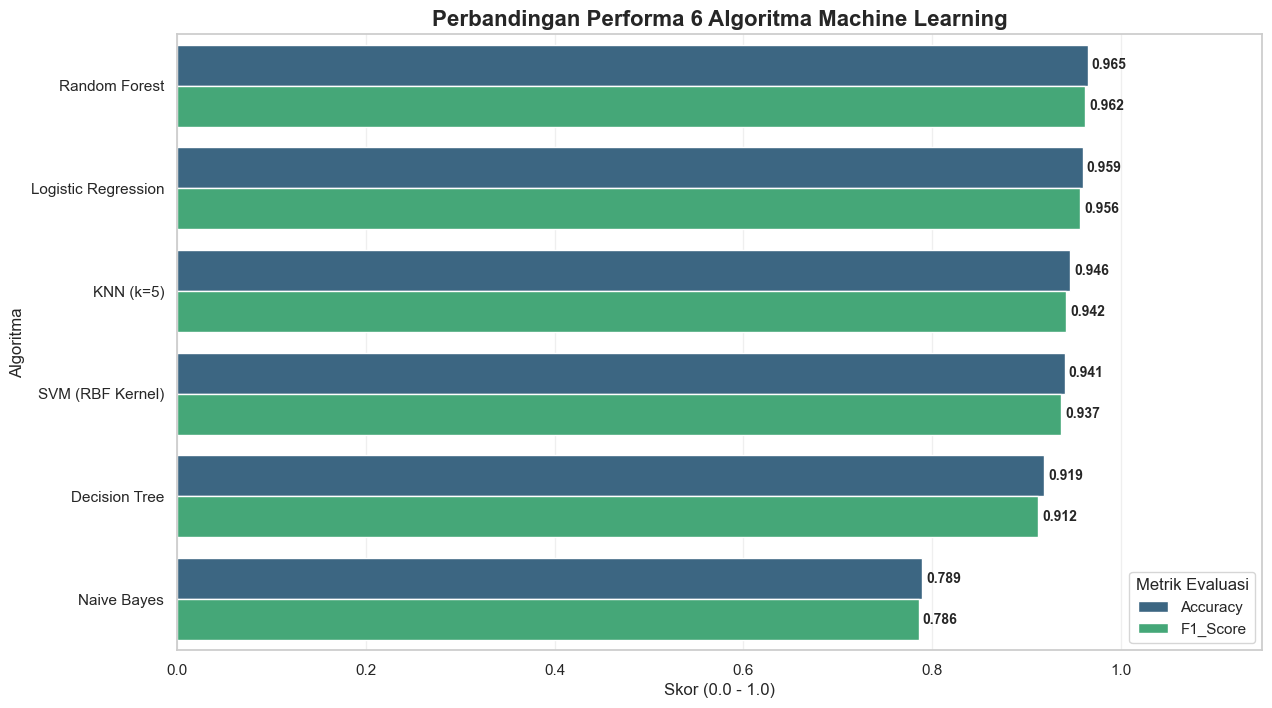

ANALISIS:
   - Grafik di atas membandingkan model berdasarkan dua metrik utama.
   - Pemenang (Random Forest) memiliki batang paling panjang dan stabil di kedua metrik.
   - Jika selisih Akurasi dan F1-Score kecil, berarti model stabil menangani data imbalance.


In [14]:
print("VISUALISASI KOMPARASI MODEL (Accuracy vs F1-Score)")

# Menyiapkan Data untuk Plotting (Melting)
df_plot = df_results.melt(id_vars='Model', 
                          value_vars=['Accuracy', 'F1_Score'], 
                          var_name='Metrik', 
                          value_name='Skor')

# Plotting
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Skor', y='Model', hue='Metrik', data=df_plot, palette='viridis')

# Dekorasi
plt.title("Perbandingan Performa 6 Algoritma Machine Learning", fontsize=16, fontweight='bold')
plt.xlabel("Skor (0.0 - 1.0)", fontsize=12)
plt.ylabel("Algoritma", fontsize=12)
plt.xlim(0, 1.15) # Beri ruang untuk label angka
plt.grid(axis='x', alpha=0.3)
plt.legend(title="Metrik Evaluasi", loc='lower right')

# Tambahkan Label Angka di Ujung Batang
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=10, fontweight='bold')

plt.show()

print("ANALISIS:")
print("   - Grafik di atas membandingkan model berdasarkan dua metrik utama.")
print(f"   - Pemenang ({best_model_name}) memiliki batang paling panjang dan stabil di kedua metrik.")
print("   - Jika selisih Akurasi dan F1-Score kecil, berarti model stabil menangani data imbalance.")

# Simpan model terbaik ke variabel global 'model_final'
model_final = best_model_obj

### Confusion Matrix

EVALUASI MENDALAM: RANDOM FOREST

Laporan Klasifikasi Lengkap:
                     precision    recall  f1-score   support

   Authentic (Asli)       0.94      0.96      0.95       132
Adulterated (Palsu)       0.98      0.97      0.97       238

           accuracy                           0.96       370
          macro avg       0.96      0.96      0.96       370
       weighted avg       0.97      0.96      0.96       370



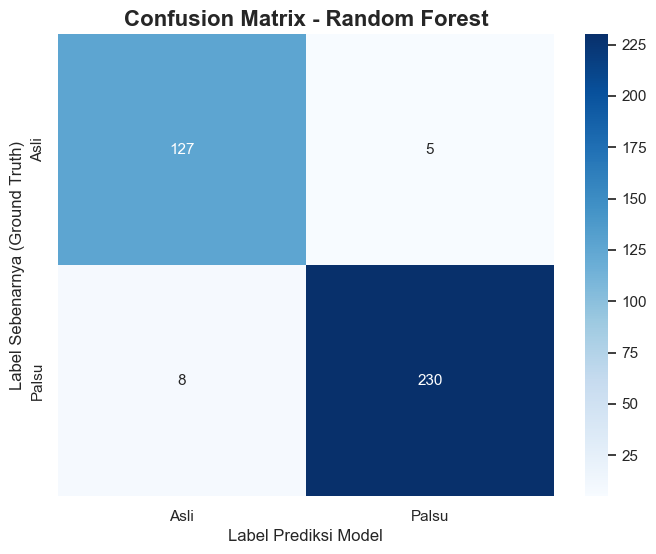

CARA BACA CONFUSION MATRIX:
   - Benar Prediksi ASLI (True Pos): 127 sampel.
   - Benar Prediksi PALSU (True Neg): 230 sampel.
   - Salah Prediksi (Asli dibilang Palsu): 5 sampel -> Bahaya! (Rejecting good product)
   - Salah Prediksi (Palsu dibilang Asli): 8 sampel -> Bahaya! (Accepting fake product)


In [15]:
print(f"EVALUASI MENDALAM: {best_model_name.upper()}")

# Prediksi ulang menggunakan model terbaik
y_pred_final = model_final.predict(X_test_scaled)

# Tampilkan Classification Report
print("\nLaporan Klasifikasi Lengkap:")
print(classification_report(y_test, y_pred_final, target_names=['Authentic (Asli)', 'Adulterated (Palsu)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Asli', 'Palsu'], yticklabels=['Asli', 'Palsu'])
plt.title(f"Confusion Matrix - {best_model_name}", fontweight='bold')
plt.ylabel("Label Sebenarnya (Ground Truth)")
plt.xlabel("Label Prediksi Model")
plt.show()

print("CARA BACA CONFUSION MATRIX:")
print(f"   - Benar Prediksi ASLI (True Pos): {cm[0,0]} sampel.")
print(f"   - Benar Prediksi PALSU (True Neg): {cm[1,1]} sampel.")
print(f"   - Salah Prediksi (Asli dibilang Palsu): {cm[0,1]} sampel -> Bahaya! (Rejecting good product)")
print(f"   - Salah Prediksi (Palsu dibilang Asli): {cm[1,0]} sampel -> Bahaya! (Accepting fake product)")

## 5. EVALUASI  

Setelah mendapatkan model terbaik, kita tidak cukup hanya melihat akurasi. Kita perlu menjawab pertanyaan: **"Mengapa model memutuskan sebuah sampel itu Palsu?"**

Fokus evaluasi tahap ini:
1.  **Feature Importance (Permutation Method):** Mengidentifikasi titik panjang gelombang (*wavelength*) mana yang paling krusial dalam membedakan stroberi asli vs oplosan.
2.  **ROC-AUC Curve:** Mengukur seberapa mampu model memisahkan kedua kelas pada berbagai *threshold*.

### Analisis Feature Importance

In [16]:
print("ANALISIS FITUR PENTING (Permutation Importance)")
print("Sedang menghitung dampak setiap panjang gelombang terhadap model")

if 'model_final' in locals():
    # Hitung Permutation Importance
    results = permutation_importance(model_final, X_test_scaled, y_test, scoring='f1_macro', n_repeats=10, random_state=42)
    
    # Ambil nilai rata-rata importance
    importances = results.importances_mean
    
    # Urutkan dari yang paling penting
    sorted_idx = importances.argsort()[::-1] # Descending
    
    # Tampilkan Top 10 Fitur Paling Berpengaruh
    print("\nTOP 10 PANJANG GELOMBANG PENENTU (Wavelength Indices):")
    print(f"{'RANK':<5} | {'INDEX FITUR':<15} | {'IMPORTANCE SCORE':<15}")
    print("-" * 45)
    
    for i in range(10):
        idx = sorted_idx[i]
        score = importances[idx]
        print(f"{i+1:<5} | Fitur_{idx:<9} | {score:.6f}")
        
else:
    print("Error: Variabel 'model_final' tidak ditemukan. Pastikan Bab 4 sudah dijalankan.")
    
print("\nPerhitungan Selesai.")

ANALISIS FITUR PENTING (Permutation Importance)
Sedang menghitung dampak setiap panjang gelombang terhadap model

TOP 10 PANJANG GELOMBANG PENENTU (Wavelength Indices):
RANK  | INDEX FITUR     | IMPORTANCE SCORE
---------------------------------------------
1     | Fitur_56        | 0.008931
2     | Fitur_65        | 0.006343
3     | Fitur_140       | 0.004189
4     | Fitur_42        | 0.004129
5     | Fitur_74        | 0.003900
6     | Fitur_71        | 0.003283
7     | Fitur_70        | 0.002997
8     | Fitur_72        | 0.002997
9     | Fitur_67        | 0.002997
10    | Fitur_196       | 0.002997

Perhitungan Selesai.


### Visualisasi Feature Importance

VISUALISASI SPEKTRUM PENTING


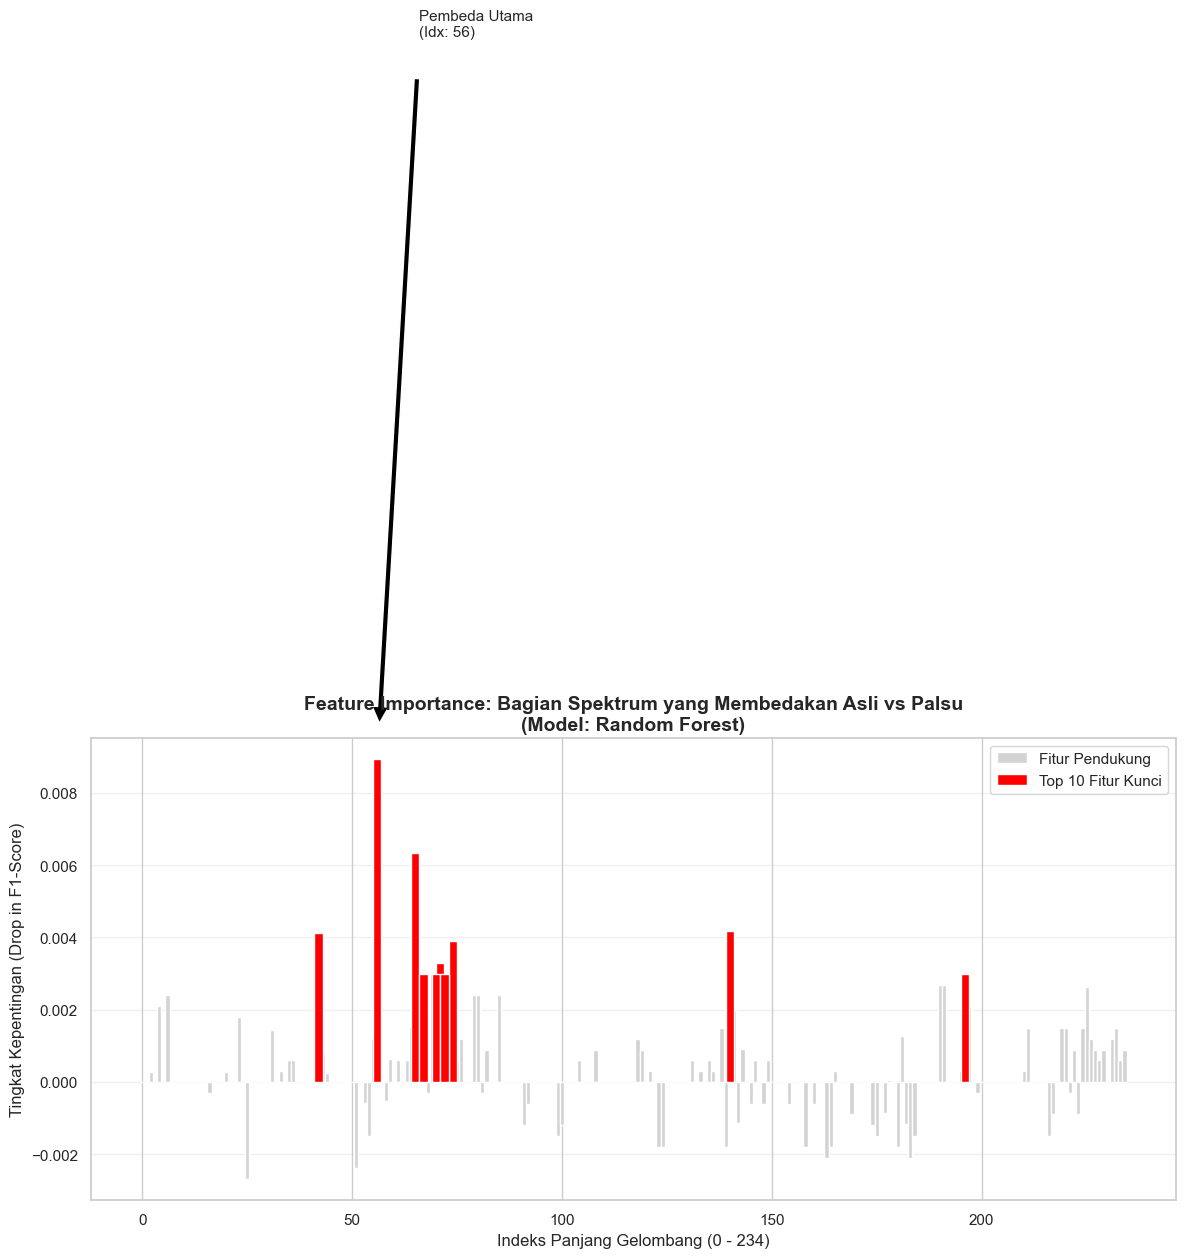

INTERPRETASI BISNIS & KIMIA:
1. Grafik di atas bukan sekadar angka. Puncak-puncak merah adalah 'lokasi' di mana pemalsuan terdeteksi.
2. Fitur ke-56 adalah indikator terkuat.
3. Jika dikaitkan dengan ilmu pangan, panjang gelombang ini mungkin berkaitan dengan
   gugus fungsi kimia tertentu (misal: ikatan O-H air atau C-H gula) yang kadarnya berbeda antara stroberi asli dan oplosan.


In [17]:
if 'importances' in locals():
    print("VISUALISASI SPEKTRUM PENTING")
    
    plt.figure(figsize=(14, 6))
    
    # Plot semua fitur
    plt.bar(range(len(importances)), importances, color='lightgray', width=1.0, label='Fitur Pendukung')
    
    # Highlight Top 10 Fitur dengan warna merah
    plt.bar(sorted_idx[:10], importances[sorted_idx[:10]], color='red', width=2.0, label='Top 10 Fitur Kunci')
    
    # Dekorasi
    plt.title(f"Feature Importance: Bagian Spektrum yang Membedakan Asli vs Palsu\n(Model: {best_model_name})", fontsize=14, fontweight='bold')
    plt.xlabel("Indeks Panjang Gelombang (0 - 234)", fontsize=12)
    plt.ylabel("Tingkat Kepentingan (Drop in F1-Score)", fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # Tambahkan anotasi pada puncak tertinggi
    top_feature = sorted_idx[0]
    plt.annotate(f'Pembeda Utama\n(Idx: {top_feature})', 
                 xy=(top_feature, importances[top_feature]), 
                 xytext=(top_feature+10, importances[top_feature]+0.02),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.show()
    
    print("INTERPRETASI BISNIS & KIMIA:")
    print("1. Grafik di atas bukan sekadar angka. Puncak-puncak merah adalah 'lokasi' di mana pemalsuan terdeteksi.")
    print(f"2. Fitur ke-{top_feature} adalah indikator terkuat.")
    print("3. Jika dikaitkan dengan ilmu pangan, panjang gelombang ini mungkin berkaitan dengan")
    print("   gugus fungsi kimia tertentu (misal: ikatan O-H air atau C-H gula) yang kadarnya berbeda antara stroberi asli dan oplosan.")

### Kurva ROC-AUC Seluruh Model

KURVA ROC Seluruh Model


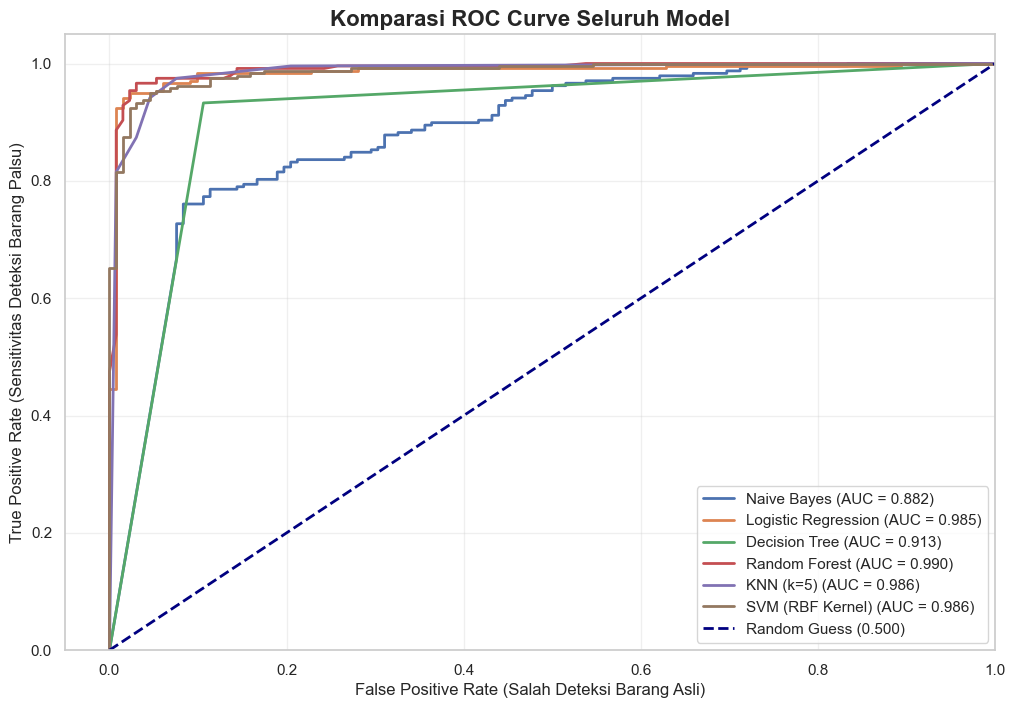

KETERANGAN:
1. [Posisi Garis]: Semakin garis melengkung ke POJOK KIRI ATAS, semakin hebat modelnya.
2. [Nilai AUC]: Lihat legenda. Nilai tertinggi (mendekati 1.000) adalah pemenangnya.
3. [Stabilitas]: Jika ada model yang garisnya patah-patah atau di bawah garis putus-putus biru, berarti model itu buruk.


In [18]:
print("KURVA ROC Seluruh Model")

plt.figure(figsize=(12, 8))

for name, model in models.items():
    try:
        # Cek apakah model mendukung probabilitas
        if hasattr(model, "predict_proba"):
            y_test_bin = np.where(y_test == 2, 1, 0)
            
            # Prediksi Probabilitas 
            probs = model.predict_proba(X_test_scaled)[:, 1]
            
            # Hitung FPR, TPR, AUC
            fpr, tpr, _ = roc_curve(y_test_bin, probs)
            roc_auc = auc(fpr, tpr)
            
            # Plot Garis Model
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
            
    except Exception as e:
        print(f"Skip {name}: {e}")

# Plot Garis Tebakan Acak (Baseline)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (0.500)')

# Dekorasi Grafik
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Salah Deteksi Barang Asli)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivitas Deteksi Barang Palsu)', fontsize=12)
plt.title('Komparasi ROC Curve Seluruh Model', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print("KETERANGAN:")
print("1. [Posisi Garis]: Semakin garis melengkung ke POJOK KIRI ATAS, semakin hebat modelnya.")
print("2. [Nilai AUC]: Lihat legenda. Nilai tertinggi (mendekati 1.000) adalah pemenangnya.")
print("3. [Stabilitas]: Jika ada model yang garisnya patah-patah atau di bawah garis putus-putus biru, berarti model itu buruk.")

### Kurva ROC-AUC Model Terbaik

KURVA ROC Model Terbaik


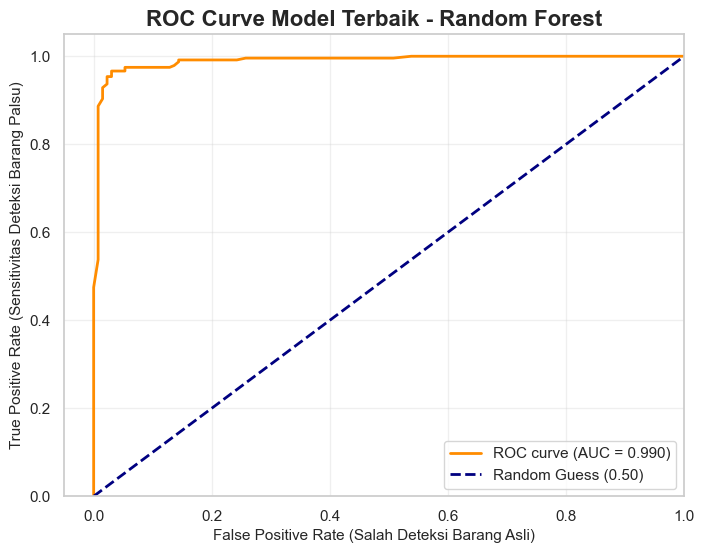

KETERANGAN:
   - Nilai AUC (Area Under Curve) adalah 0.990 (Sempurna = 1.0).
   - Semakin kurva mendekat ke pojok kiri atas, semakin hebat model memisahkan barang asli dan palsu
     tanpa banyak melakukan kesalahan (False Alarm).


In [19]:
print("KURVA ROC Model Terbaik")

# Cek predict_proba (Probabilitas)
if hasattr(model_final, "predict_proba"):
    # Binarisasi Label sementara untuk keperluan plot ROC
    y_test_bin = np.where(y_test == 2, 1, 0)
    
    # Prediksi Probabilitas
    y_prob = model_final.predict_proba(X_test_scaled)[:, 1] # Ambil probabilitas kelas Palsu
    
    # Hitung FPR, TPR, Thresholds
    fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (0.50)')
    
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (Salah Deteksi Barang Asli)', fontsize=11)
    plt.ylabel('True Positive Rate (Sensitivitas Deteksi Barang Palsu)', fontsize=11)
    plt.title(f"ROC Curve Model Terbaik - {best_model_name}", fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("KETERANGAN:")
    print(f"   - Nilai AUC (Area Under Curve) adalah {roc_auc:.3f} (Sempurna = 1.0).")
    print("   - Semakin kurva mendekat ke pojok kiri atas, semakin hebat model memisahkan barang asli dan palsu")
    print("     tanpa banyak melakukan kesalahan (False Alarm).")

else:
    print(f"Model {best_model_name} tidak mendukung probabilitas (predict_proba), visualisasi ROC dilewati.")

### PENYIMPANAN MODEL

Model terbaik yang telah dilatih dan dievaluasi kini siap untuk disimpan. Kita tidak hanya menyimpan model klasifikasi, tetapi juga objek **Scaler** (*StandardScaler*) yang digunakan untuk normalisasi data.

**Komponen yang Disimpan:**
1.  `model_strawberry.pkl`: Otak pemrosesan (Algoritma Machine Learning terpilih).
2.  `scaler_strawberry.pkl`: Standarisasi data (Agar input dari aplikasi memiliki rentang nilai yang sama dengan data latih).

Kedua file ini nantinya akan dipindahkan ke folder aplikasi **Streamlit** untuk proses deployment.

In [20]:
print("MENYIMPAN MODEL & SCALER")

# Pastikan variabel model dan scaler tersedia
if 'model_final' in locals() and 'scaler' in locals():
    
    # Tentukan Nama File
    model_filename = 'model_strawberry.pkl'
    scaler_filename = 'scaler_strawberry.pkl'
    
    # Proses Penyimpanan (Serialization)
    try:
        joblib.dump(model_final, model_filename)
        joblib.dump(scaler, scaler_filename)
        
        print(f"Berhasil menyimpan Model  -> {model_filename}")
        print(f"Berhasil menyimpan Scaler -> {scaler_filename}")
        
        # Cek ukuran file
        size_model = os.path.getsize(model_filename) / 1024
        print(f"Ukuran Model: {size_model:.2f} KB")
        
    except Exception as e:
        print(f"Gagal menyimpan: {e}")

else:
    print("Error: Variabel 'model_final' atau 'scaler' tidak ditemukan.")

MENYIMPAN MODEL & SCALER
Berhasil menyimpan Model  -> model_strawberry.pkl
Berhasil menyimpan Scaler -> scaler_strawberry.pkl
Ukuran Model: 416.24 KB


### Simulasi Prediksi

Simulasi Prediksi
SAMPEL TEST INDEX: 202
LABEL ASLI      : Adulterated (Oplosan)
PREDIKSI MODEL  : Adulterated (Oplosan)
HASIL           : BENAR (Confidence: 100.00%)


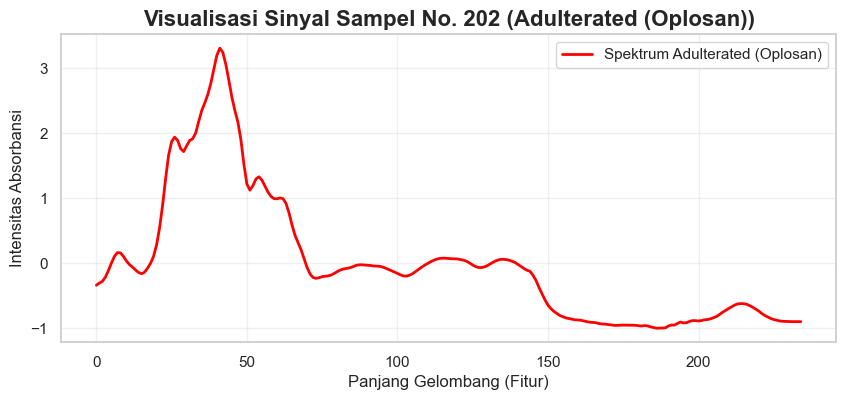

In [21]:
print("Simulasi Prediksi")

# LOAD MODEL & SCALER (Pura-pura kita di aplikasi Streamlit)
try:
    loaded_model = joblib.load('model_strawberry.pkl')
    loaded_scaler = joblib.load('scaler_strawberry.pkl')
    
    # PILIH 1 SAMPEL ACAK DARI DATA TEST
    random_idx = random.randint(0, len(X_test) - 1)
    
    sample_raw = X_test[random_idx].reshape(1, -1) # Bentuk harus 2D (1 baris, n kolom)
    true_label_code = y_test[random_idx]
    true_label_text = class_map[true_label_code]
    
    # PREPROCESSING (Wajib Scale menggunakan Scaler yang dimuat)
    sample_scaled = loaded_scaler.transform(sample_raw)
    
    # PREDIKSI
    pred_code = loaded_model.predict(sample_scaled)[0]
    pred_text = class_map[pred_code]
    
    # Ambil probabilitas/confidence (jika model mendukung)
    confidence = 0.0
    if hasattr(loaded_model, "predict_proba"):
        probs = loaded_model.predict_proba(sample_scaled)[0]
        confidence = probs[1] if pred_code == 2 else probs[0] # Ambil probabilitas kelas terpilih
    
    # TAMPILKAN HASIL (Text & Visual)
    print("="*60)
    print(f"SAMPEL TEST INDEX: {random_idx}")
    print(f"LABEL ASLI      : {true_label_text}")
    print(f"PREDIKSI MODEL  : {pred_text}")
    
    # Cek Kebenaran
    status = "BENAR" if pred_code == true_label_code else "SALAH"
    print(f"HASIL           : {status} (Confidence: {confidence:.2%})")
    print("="*60)
    
    # VISUALISASI SPEKTRUM
    plt.figure(figsize=(10, 4))
    
    # Plot Garis Spektrum Sampel Terpilih
    color_line = 'green' if true_label_code == 1 else 'red'
    plt.plot(sample_raw[0], color=color_line, linewidth=2, label=f'Spektrum {true_label_text}')
    
    plt.title(f"Visualisasi Sinyal Sampel No. {random_idx} ({true_label_text})", fontweight='bold')
    plt.xlabel("Panjang Gelombang (Fitur)")
    plt.ylabel("Intensitas Absorbansi")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

except Exception as e:
    print(f"Terjadi kesalahan: {e}")

## 6. Deployment  

### Load dan simpan model pada folder deploy

In [22]:
print("Load & Simpan model ke folder deploy")
print("="*50)

# Definisikan file aset dari pipeline kita
MODEL_FILE = "model_strawberry.pkl"
SCALER_FILE = "scaler_strawberry.pkl"

# Kumpulkan semua file dalam satu list
FILE_LIST_TO_COPY = [
    MODEL_FILE,
    SCALER_FILE,
]

# folder tujuan
SAVE_DIR = "../psd_deploy_uas"
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Folder tujuan disiapkan: {SAVE_DIR}")

# Buat fungsi copy yang efisien menggunakan shutil
def copy_file_to_deploy(source_path, target_dir):
    # Periksa apakah file sumber ada
    if not os.path.exists(source_path):
        print(f"File tidak ditemukan: {source_path}")
        return

    try:
        # Menyalin file secara langsung
        target_path = shutil.copy(source_path, target_dir)
        print(f"{os.path.basename(source_path)} berhasil disalin ke: {target_path}")
    except Exception as e:
        print(f"Gagal menyalin {source_path}: {e}")

# Eksekusi untuk semua file
print("\nMulai menyalin file aset ke folder deploy...")
for file_path in FILE_LIST_TO_COPY:
    copy_file_to_deploy(file_path, SAVE_DIR)

print("\nSemua file aset berhasil disalin ke folder deploy!")

Load & Simpan model ke folder deploy
Folder tujuan disiapkan: ../psd_deploy_uas

Mulai menyalin file aset ke folder deploy...
model_strawberry.pkl berhasil disalin ke: ../psd_deploy_uas\model_strawberry.pkl
scaler_strawberry.pkl berhasil disalin ke: ../psd_deploy_uas\scaler_strawberry.pkl

Semua file aset berhasil disalin ke folder deploy!


### Membuat file `app.py` dengan code:  

```python
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import plotly.graph_objects as go

# KONFIGURASI HALAMAN
st.set_page_config(
    page_title="Strawberry Quality Check",
    page_icon="🍓",
    layout="centered"
)

# CSS CUSTOMIZATION
st.markdown("""
<style>
    /* Mengatur Font Global */
    html, body, [class*="css"] {
        font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif;
    }
    
    /* Header Utama */
    .main-header {
        background: linear-gradient(90deg, #C70039 0%, #900C3F 100%);
        padding: 20px;
        border-radius: 10px;
        color: white;
        text-align: center;
        margin-bottom: 30px;
        box-shadow: 0 4px 15px rgba(0,0,0,0.2);
    }
    .main-header h1 {
        font-size: 28px;
        font-weight: 700;
        margin: 0;
        color: white;
    }
    .main-header p {
        font-size: 14px;
        margin-top: 5px;
        opacity: 0.9;
    }

    /* Styling Tombol */
    .stButton>button {
        width: 100%;
        background-color: #C70039;
        color: white;
        font-weight: 600;
        border-radius: 8px;
        height: 50px;
        border: none;
        transition: all 0.3s ease;
    }
    .stButton>button:hover {
        background-color: #900C3F;
        box-shadow: 0 5px 15px rgba(199, 0, 57, 0.4);
        transform: translateY(-2px);
    }

    /* Result Card Styling */
    .result-card {
        background-color: white;
        padding: 25px;
        border-radius: 15px;
        text-align: center;
        box-shadow: 0 10px 25px rgba(0,0,0,0.08);
        border-top: 5px solid #ccc;
        color: #333;
    }
    
    /* Status Colors */
    .status-authentic {
        border-top-color: #28a745 !important;
    }
    .status-adulterated {
        border-top-color: #dc3545 !important;
    }
    
    .result-title {
        font-size: 24px;
        font-weight: 800;
        margin-bottom: 10px;
        text-transform: uppercase;
        letter-spacing: 1px;
    }
    .result-desc {
        font-size: 16px;
        color: #666;
        line-height: 1.5;
    }
</style>
""", unsafe_allow_html=True)

# LOAD MODEL & SCALER
@st.cache_resource
def load_resources():
    try:
        # Load Model dan Scaler
        model = joblib.load('model_strawberry.pkl')
        scaler = joblib.load('scaler_strawberry.pkl')
        return model, scaler
    except Exception as e:
        return None, None

# HEADER INTERFACE
st.markdown("""
<div class='main-header'>
    <h1>SISTEM DETEKSI KEASLIAN STROBERI</h1>
    <p>Analisis Spektroskopi Berbasis Machine Learning</p>
</div>
""", unsafe_allow_html=True)

# Load resources
model, scaler = load_resources()

if model is None or scaler is None:
    st.error("SYSTEM ERROR: File model atau scaler tidak ditemukan. Harap unggah file .pkl.")
    st.stop()

# SIDEBAR 
with st.sidebar:
    st.markdown("### SUMBER DATASET")
    st.caption("Model ini dilatih menggunakan dataset publik:")
    st.markdown(
        "[UCR Strawberry Dataset](https://www.timeseriesclassification.com/description.php?Dataset=Strawberry)",
        unsafe_allow_html=True
    )
    
    st.markdown("### INFORMASI")
    st.info("""
    - **Metode:** Random Forest Classifier
    - *Input:** 235 Titik Gelombang Spektrum
    - **Output:** Binary Classification
    """)
    
    st.markdown("---")
    st.markdown("**Panduan:**")
    st.text("1. Siapkan file .txt/.csv hasil Scan Spektroskopi.")
    st.text("2. Pastikan format data numerik.")
    st.text("3. Klik tombol analisis.")

# UPLOAD DATA
st.write("### 1. Upload Data Sampel")
uploaded_file = st.file_uploader("", type=['txt', 'csv'], help="Unggah file spektroskopi mentah di sini")

input_data = None 

if uploaded_file is not None:
    try:
        content = uploaded_file.getvalue().decode("utf-8")
        
        # Deteksi pemisah
        if "," in content.split('\n')[0]:
            sep = ","
        else:
            sep = r"\s+"
            
        uploaded_file.seek(0)
        df = pd.read_csv(uploaded_file, header=None, sep=sep)
        data_values = df.values
        
        # Handling Kolom
        if data_values.shape[1] > 235:
            st.toast(f"Info: Memotong kolom label. Menggunakan 235 fitur terakhir.", icon=None)
            input_data = data_values[:, 1:] 
        elif data_values.shape[1] == 235:
            input_data = data_values
        else:
            st.error(f"FORMAT ERROR: Data memiliki {data_values.shape[1]} kolom. Dibutuhkan 235 kolom.")
            st.stop()

        # Ambil sampel pertama
        input_data = input_data.astype(float)
        input_data = input_data[0].reshape(1, -1)
        
        # Tampilkan preview data mini dalam expander
        with st.expander("Lihat Data Mentah"):
            st.dataframe(pd.DataFrame(input_data), hide_index=True)

    except Exception as e:
        st.error(f"Gagal membaca file: {e}")
        st.stop()

# VISUALISASI & PREDIKSI
if input_data is not None:
    
    st.write("### 2. Analisis Spektrum")
    
    # CHART
    x_axis = np.arange(235)
    y_axis = input_data[0]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=x_axis, 
        y=y_axis, 
        mode='lines', 
        name='Sampel',
        line=dict(color='#C70039', width=3),
        fill='tozeroy', 
        fillcolor='rgba(199, 0, 57, 0.1)'
    ))
    
    fig.update_layout(
        title="Visualisasi Gelombang Spektroskopi",
        xaxis_title="Titik Panjang Gelombang",
        yaxis_title="Intensitas Absorbansi",
        template="plotly_white",
        height=350,
        margin=dict(l=20, r=20, t=40, b=20),
        hovermode="x"
    )
    st.plotly_chart(fig, use_container_width=True)

    # TOMBOL PREDIKSI
    st.write("### 3. Hasil Diagnosa")
    
    col_btn_1, col_btn_2, col_btn_3 = st.columns([1, 2, 1])
    with col_btn_2:
        predict_btn = st.button("JALANKAN ANALISIS")
    
    if predict_btn:
        with st.spinner("Sedang memproses algoritma..."):
            import time
            time.sleep(0.8)
            
            # PREDIKSI
            input_scaled = scaler.transform(input_data)
            prediction = model.predict(input_scaled)[0]
            
            # Hitung Probabilitas
            if hasattr(model, "predict_proba"):
                probs = model.predict_proba(input_scaled)[0]
                confidence = np.max(probs) * 100
            else:
                confidence = 100.0
            
            # LOGIKA HASIL
            if prediction == 1:
                label_text = "AUTHENTIC (ASLI)"
                desc_text = "Sampel terverifikasi memiliki profil kimia stroberi murni."
                status_class = "status-authentic"
                text_color = "#28a745"
                gauge_color = "#28a745"
            else:
                label_text = "ADULTERATED (OPLOSAN)"
                desc_text = "Terdeteksi anomali komposisi kimia pada sampel."
                status_class = "status-adulterated"
                text_color = "#dc3545"
                gauge_color = "#dc3545"

            # TAMPILAN HASIL DASHBOARD
            col_res1, col_res2 = st.columns([1.5, 1])
            
            # Kolom Kiri: Teks Penjelasan
            with col_res1:
                st.markdown(f"""
                <div class='result-card {status_class}'>
                    <div style='color: #888; font-size: 12px; margin-bottom: 5px;'>HASIL PREDIKSI</div>
                    <div class='result-title' style='color: {text_color};'>{label_text}</div>
                    <div class='result-desc'>{desc_text}</div>
                </div>
                """, unsafe_allow_html=True)
                
                # Tampilkan detail probabilitas jika ada
                if hasattr(model, "predict_proba"):
                    st.caption("Distribusi Probabilitas Model:")
                    prob_df = pd.DataFrame(probs.reshape(1, -1), columns=model.classes_)
                    st.bar_chart(prob_df.T, color=text_color, height=150)

            # Kolom Kanan: Gauge Chart (Spidometer)
            with col_res2:
                fig_gauge = go.Figure(go.Indicator(
                    mode = "gauge+number",
                    value = confidence,
                    title = {'text': "Tingkat Keyakinan", 'font': {'size': 14, 'color': '#555'}},
                    number = {'suffix': "%", 'font': {'size': 20}},
                    gauge = {
                        'axis': {'range': [0, 100], 'tickwidth': 1, 'tickcolor': "#333"},
                        'bar': {'color': gauge_color},
                        'bgcolor': "white",
                        'borderwidth': 2,
                        'bordercolor': "#eee",
                        'steps': [
                            {'range': [0, 50], 'color': '#f9f9f9'},
                            {'range': [50, 100], 'color': '#f0f0f0'}
                        ],
                    }
                ))
                fig_gauge.update_layout(height=250, margin=dict(l=20, r=20, t=10, b=10))
                st.plotly_chart(fig_gauge, use_container_width=True)
```

Link GitHub: https://github.com/AqbilBarakaa/psd_deploy_uas

### Mempersiapkan lingkungan aplikasi

In [23]:
%pip install streamlit pandas numpy joblib plotly scikit-learn

Note: you may need to restart the kernel to use updated packages.


### Menjalankan Aplikasi  

```streamlit run app.py```

### Hasil Deploy:  

https://psddeployuas.streamlit.app/

## Link Google Drive Untuk Dataset dan File Kompresi  

[Dataset dan File Kompresi](https://drive.google.com/drive/folders/1ikzEt1sl4IAX7AE1urrURLE5QgZP0keO?usp=sharing)